In [48]:
import pandas as pd 
dataset = pd.read_csv('train.csv')
dataset_test = pd.read_csv('test.csv')
# create the label
dataset["is_bad_review"] = dataset["category"].apply(lambda x: 1 if x == 1 else 0)
# select only relevant columns
dataset = dataset[["review_text", "category"]]
dataset.head()

,review_text,category
0,"Penginapannya rapi, bersih, suasana tenang, pe...",1
1,"wifi tidak sampai kamar, tidak tersedia heater...",0
2,"Lantai kamar mandi kotor, bau, dan seperti sdh...",0
3,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...",0
4,bocor lagi,0


In [2]:
#dataset = dataset.sample(frac = 0.1, replace = False, random_state=42)

In [6]:
#dataset["review_text"] = dataset["review_text"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

In [49]:
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

# def get_wordnet_pos(pos_tag):
#     if pos_tag.startswith('J'):
#         return wordnet.ADJ
#     elif pos_tag.startswith('V'):
#         return wordnet.VERB
#     elif pos_tag.startswith('N'):
#         return wordnet.NOUN
#     elif pos_tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN

import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('indonesian')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    #text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
dataset["review_clean"] = dataset["review_text"].apply(lambda x: clean_text(x))
dataset_test["review_clean"] = dataset_test["review_text"].apply(lambda x: clean_text(x))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ms\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [30]:
# add sentiment anaylsis columns
# import nltk
# nltk.download('vader_lexicon')
# from nltk.sentiment.vader import SentimentIntensityAnalyzer

# sid = SentimentIntensityAnalyzer()
# dataset["sentiments"] = dataset["review_text"].apply(lambda x: sid.polarity_scores(x))
# dataset = pd.concat([dataset.drop(['sentiments'], axis=1), dataset['sentiments'].apply(pd.Series)], axis=1)

In [31]:
# add number of characters column
#dataset["nb_chars"] = dataset["review_text"].apply(lambda x: len(x))

# add number of words column
#dataset["nb_words"] = dataset["review_text"].apply(lambda x: len(x.split(" ")))


In [7]:
pip install -U gensim

Requirement already up-to-date: gensim in c:\users\ms\anaconda3\lib\site-packages (3.8.3)
Note: you may need to restart the kernel to use updated packages.


In [50]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(dataset["review_clean"].apply(lambda x: x.split(" ")))]
documents_test = [TaggedDocument(doc, [i]) for i, doc in enumerate(dataset_test["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = dataset["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
dataset = pd.concat([dataset, doc2vec_df], axis=1)

doc2vec_df_test = dataset_test["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df_test.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df_test.columns]
dataset_test = pd.concat([dataset_test, doc2vec_df_test], axis=1)

In [98]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
x = tfidf.fit_transform(dataset["review_clean"]).toarray()
# tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
# tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
# tfidf_df.index = dataset.index
# dataset = pd.concat([dataset, tfidf_df], axis=1)

x_test = tfidf.transform(dataset_test["review_clean"]).toarray()
# tfidf_df_test = pd.DataFrame(tfidf_result_test, columns = tfidf.get_feature_names())
# tfidf_df_test.columns = ["word_" + str(x) for x in tfidf_df_test.columns]
# tfidf_df_test.index = dataset_test.index
# dataset_test = pd.concat([dataset_test, tfidf_df_test], axis=1)



In [99]:
# show is_bad_review distribution
dataset["category"].value_counts(normalize = True)


0    0.86423
1    0.13577
Name: category, dtype: float64

In [100]:
dataset.shape

(14856, 5051)

In [101]:
dataset_test.shape

(3714, 2275)

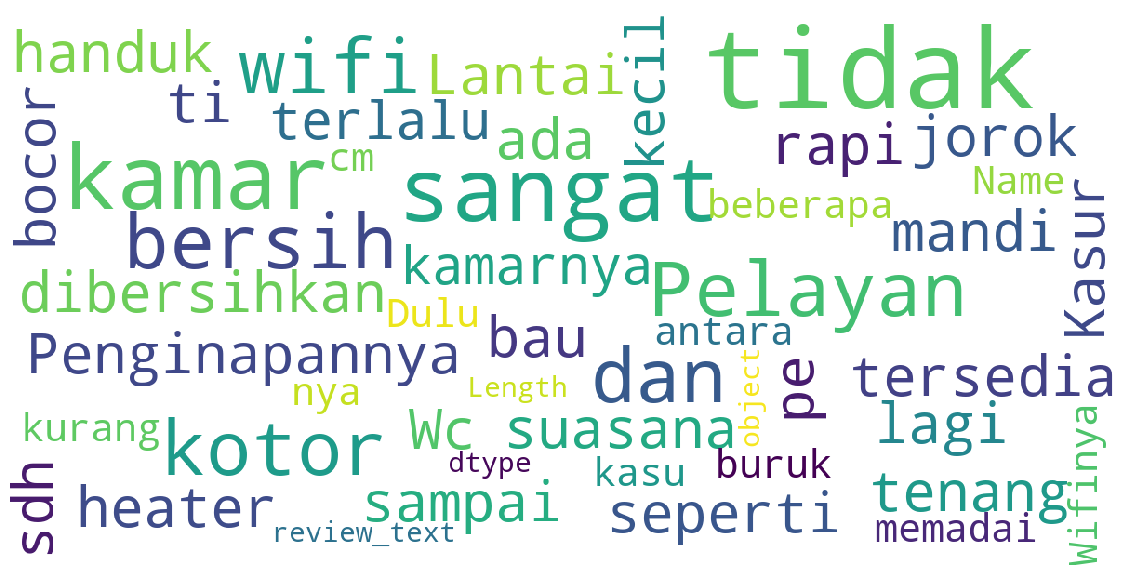

In [102]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(dataset["review_text"])

In [12]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [39]:
# highest positive sentiment reviews (with more than 5 words)
#dataset[dataset["nb_words"] >= 5].sort_values("positive", ascending = False)[["review_text", "positive"]].head(10)

In [38]:
# lowest negative sentiment reviews (with more than 5 words)
#dataset[dataset["nb_words"] >= 5].sort_values("neg", ascending = False)[["review_text", "neg"]].head(10)

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

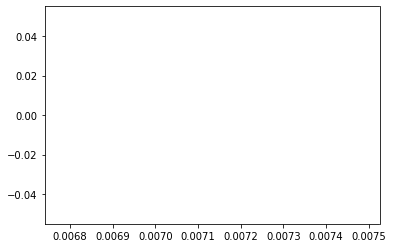

In [41]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = dataset[dataset['category'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

In [103]:
# feature selection
label = "category"
ignore_cols = [label, "review_text", "review_clean"]
ignore_cols_test = [label, "review_text", "review_clean", "review_id"]
features = [c for c in dataset.columns if c not in ignore_cols]
features_test = [c for c in dataset_test.columns if c not in ignore_cols_test]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# x = dataset[features]
y = dataset[label]
# x_test = dataset_test[features_test]

#X_train, X_test, y_train, y_test = train_test_split(dataset[features], dataset[label], test_size = 0.20, random_state = 42)


In [104]:
x.shape

(14856, 1681)

In [105]:
x_test.shape

(3714, 1681)

In [106]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(x, y)

# show feature importance
#feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
#feature_importances_df.head(20)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [81]:
print(x_test)

      doc2vec_vector_0  doc2vec_vector_1  doc2vec_vector_2  doc2vec_vector_3  \
0            -0.048923         -0.105465          0.051659          0.116862   
1            -0.049665         -0.072385          0.100813          0.007270   
2            -0.125479         -0.007537          0.007621         -0.089350   
3            -0.089977         -0.125432          0.062033         -0.071394   
4             0.069613          0.013581          0.090227         -0.048373   
...                ...               ...               ...               ...   
3709         -0.158915         -0.025613          0.083208         -0.033991   
3710         -0.061270         -0.047327          0.032665          0.088009   
3711          0.030715         -0.189431          0.016328          0.042092   
3712         -0.069214          0.061631          0.058203          0.064750   
3713         -0.042301          0.064270         -0.015982         -0.072794   

      doc2vec_vector_4   word_ac   word

In [108]:
pred = rf.predict(x_test) 

In [109]:
print(pred)

[0 0 0 ... 0 0 0]


In [110]:
predictions = pd.DataFrame(pred, columns=['category'])
print(predictions)

      category
0            0
1            0
2            0
3            0
4            0
...        ...
3709         0
3710         0
3711         0
3712         0
3713         0

[3714 rows x 1 columns]


In [112]:
review_test_data = pd.read_csv('test.csv')

In [113]:
submission = pd.DataFrame(review_test_data, columns=['review_id'])
submission['category'] = predictions
print(submission)

                             review_id  category
0     7302180ac7160f04a405d8aa7bd6beb8         0
1     3184c670e170f565c7522eb76a320ba1         0
2     e33abf6bb5d5a9a77c339043b1725dc8         0
3     061d388950340070a6ac03fabc9027b0         0
4     e62d87c348674b6c06856964f3ab16b8         0
...                                ...       ...
3709  4fac4c272d9194021f921138ebd5b389         0
3710  4fabd4722dd4074841f9656f75105f09         0
3711  44ff89997547d54cccb2a33776181240         0
3712  c46cf84e3665a10199a539fee919edd6         0
3713  82d1677f2aa50eb79fb4e6f496384ef2         0

[3714 rows x 2 columns]


In [114]:
submission.to_csv('submission.csv', index=None)

In [47]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

NameError: name 'X_test' is not defined

In [20]:
pip install funcsigs

Note: you may need to restart the kernel to use updated packages.


In [23]:

# PR curve

from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.externals.fixes import signature

average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

ModuleNotFoundError: No module named 'sklearn.externals.fixes'